---
# Семинар 7. Few/Zero Shot Learning

Мы привыкли, что задача машинного обучения предполагает наличие большого количества данных. А что если:


1. Cуществуют какие-то редкие случаи, примеров которых в обучающей выборке всего несколько штук. Тогда формально мы имеем задачу классификации на $C$ классов, из них $K < C$ классов имеют мало обучающих примеров, и нужно уметь различать между всеми классами, как многочисленными, так и малочисленными.


2. Для какой-то задачи в целом может быть сложно (долго, дорого, ненадежно...) собирать какие-то данные (например компьютерная томография или МРТ). Здесь же, у нас всего $K$ классов, и для каждого из этих классов имеется мало обьектов в выборке.


Для таких задач был разработан ряд __Few Shot Learning__ алгоритмов. Если у нас $K$ редких классов, каждый из которых представлен $N$ обьектами, то в англоязычной литературе такая Few Shot задача называется __$K$-way $N$-shot__ классификацией/регрессией/детекцией/...

Сегодня мы познакомимся с решениями, которые позволяют получать адекватное качество предсказаний, несмотря на крайне маленькое (или даже совсем отсутсвующее!) количество данных.

План:
1. Metric Learning для Few Shot классификации
2. Meta Learning для Few Shot классификации
3. Zero Shot классификация


---

In [ ]:
!pip install -q pytorch_lightning

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchmetrics.functional import accuracy
from torchvision import transforms
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

Для начала соберем себе маленькую выборку. Пускай это будет подвыборка хорошо знакомой нам выборки CIFAR10, в которой 10 классов цветных изображений размера 32х32.

Сделаем класс CifarSubset, который будет представлять собой dataset состоящий из подвыборки __N__ обьектов каждого из 10 классов.

In [ ]:
class CifarSubset(torchvision.datasets.vision.VisionDataset):
    def __init__(self, root, k_n, train: bool, download: bool, transform):
        super().__init__(root, transform=transform, target_transform=None)

        self.k_n = k_n
        self.data = self.__sample_uniform_subset(root, train, download, transform)

    def __sample_uniform_subset(self, root, train, download, transform):
        """
        Метод вернет такую подвыборку выборки CIFAR10,
        что обьектов каждого класса будет ровно k_n штук.

        :param: dataset - исходная выборка
        :param: k_n - количество обьектов в каждом классе
        """

        self.cifar_full = torchvision.datasets.CIFAR10(
            root=root, train=train, download=download, transform=transform
        )

        number_of_classes = len(self.cifar_full.classes)
        class_count = [0 for _ in range(number_of_classes)]
        subset = []

        for image, label in self.cifar_full:
            # мы хотим ровно k_n обьектов каждго класса
            if class_count[label] < self.k_n:
                subset.append((image, label))
                class_count[label] += 1

            # если каждый класс имеет k_n обьектов - выходим из цикла
            if sum(class_count) == number_of_classes * self.k_n:
                break
        return subset

    def __getitem__(self, index):
        return self.data[index][0], self.data[index][1]

    def __len__(self):
        return len(self.data)

In [ ]:
N_SHOT = 5  # количество обьектов каждого класса в обучающей выборке

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train_subset = CifarSubset(
    root="./cifar", k_n=N_SHOT, train=True, download=True, transform=transform
)

cifar_val_subset = CifarSubset(
    root="./cifar", k_n=N_SHOT, train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


Многие алгоритмы для Few Shot (и особенно Meta) Learning лучше тренировать так называемыми __эпизодами__, где эпизодом называют ситуацию максимально приближенную к условиям инференса. Например, если во время инференса мы будем просить модель классифицировать __N__ обьектов каждого из __K__ классов, то и тренировать ее стоит батчами по __N__ * __K__ классов.

И так как в нашем случае __N__ * __K__ это и есть _все_ наши данные, то у нас один эпизод эквивалентен одной эпохе.

In [ ]:
# тк нам нужно обучаться эпизодами, батч должен содержать в себе сразу все данные
train_dataloader = torch.utils.data.DataLoader(
    cifar_train_subset,
    batch_size=N_SHOT * 10,  # 10 потому что в нашей выборке 10 классов
    shuffle=True,
    num_workers=1,
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val_subset, batch_size=N_SHOT * 10, shuffle=True, num_workers=1
)

Если воспользоваться решениями, которые были у нас до сегодняшнего дня, то модель просто не выучит никаких закономерностей малочисленного класса и сильно переобучится.

Чтобы продемонстрировать это, давайте возьмем какую-то умную архитектуру, предобученную на большом количестве сложных картинок и попробуем дообучить ее на нашу задачу (Finetuning).

In [ ]:
...

Ellipsis

---

## __Few Shot Metric learning__

Основная цель подходов данного вида - понять как выглядят выученные признаки (или эмбединги) типичного представителя каждого класса. Имея такие "прототипы" классов - можно будет сравнивать признаки каждого из обьектов с признаками каждого прототипа и выбирать тот, который наиболее похож на наш обьект. Для того чтобы это работало, нужно убедиться, что во время обучения мы делаем так, что похожие обьекты находятся рядом в пространстве признаков, а не похожие - далеко друг от друга(совсем как в задаче кластеризации).

---

Верхнеуровнего это всегда выглядит примерно одинаково:

1. На тех данных, что у нас имеются обучается какая-то модель, выходом которой будут __не вероятности классов__, а __многомерный вектор признаков__(можно взять любую из наших предыдущих моделей классификации/регрессии и отбросить последний классификационный слой)

2. Функция потерь подбирается таким образом, чтобы модель училась группировать между собой похожие данные

3. Как во время обучения, так и во время инференса - в случае __K__-way __N__-shot классификации (у нас __K__ классов и __N__ обьектов каждого класса) какой-то процент из __N__ обьектов каждого класса выбирается для того чтобы сформировать тот самый прототип класса путем усреднения их признаков - такая подвыборка будет называться вспомогательным множеством или __support set__, а оставшиеся обьекты(которые мы собственно будем сравнивать с этим прототипом) называется множеством запросов или __query set__.

---

1. Построим простую сверочную архитектуру, выходом которой для каждого обьекта будет многомерный вектор выученных признаков:

In [ ]:
class PrototypeNet(nn.Module):
    def __init__(self, input_dim=3, hid_dim=64, output_dim=64):
        super(PrototypeNet, self).__init__()

        self.encoder = nn.Sequential(
            self.__conv_block(input_dim, hid_dim),
            self.__conv_block(hid_dim, hid_dim),
            self.__conv_block(hid_dim, hid_dim),
            self.__conv_block(hid_dim, output_dim),
        )

    def __conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

2. Теперь нужно выбрать такой функционал потерь, который будет штрафовать за  

  - большие расстояния между объектом и прототипом его класса
  - маленькие расстояни] между обьектом и прототипом _не_ его класса

  Так как готовых решений в торче нет, придется писать свой Loss... Чтобы не подбирать математику описывающую нужные нам условия - воспользуемся подходом, представленным в [данной работе](https://arxiv.org/pdf/1703.05175.pdf). Тогда формирование функционала ошибки будет выглядеть следующим образом: 

---

- Для каждого класса $c$:
    - Для каждого обьекта $q$ из нашего __query_set($с$)__
      
  $$
  Loss +=  {1 \over N_c * N_q} * \left[\text{dist}(\text{emb}(q), p_c) + \log{\sum_{classes} e^{-\text{dist}(\text{emb}(q), p_{class})}} \right]
  $$

  где $\text{emb}(q)$ - эмбеддинг полученный после того как обьект $q$ прошел через нашу свертучную сеть, а $\text{dist}(\text{emb}(q), p_c)$ - какая-то функция расстояния между этим эмбеддингом и прототипом $p_c$ класса $c$.
---
  С первого взгляда происходит что-то страшное, и не понятно почему взяты именно такие значение. Но если приглядется, то будет понятно, что первое слагаемое в скобках - это просто расстоение нашего обьекта до прототипа своего класса, а второе значение (в виде суммы) становится тем меньше, чем дальше наш обьект от всех остальных прототипов.
  
  Таким образом минимизируя представленный функционал по параметрам нейросети - мы как раз приближаем наш обьект к своим прототипу и отдаляем от всех остальных! 

In [ ]:
class PrototypeLoss(nn.Module):
    def __init__(self, n_shot: int):
        super(PrototypeLoss, self).__init__()
        self.n_shot = n_shot
        self.__prototypes: list = None

    def __distance(self, inp, other):
        return torch.linalg.norm(inp - other)

    def __prototype_loss(
        self,
        predicted_embeddings: torch.Tensor,
        target_labels: torch.Tensor,
        support_percent=0.6,
    ):
        """
        :param: predicted_embeddings - вектора признаков полученные
                                       в результате работы модели.
                                       shape = (N, emb_size)

        :param: target_labels   - список целевых классов.
                                  shape=(N)

        :param: support_percent - процент данных каждого класса,
                                  который будет использоваться для формирования
                                  прототипа класса
        """

        assert 0 < support_percent < 1

        classes = torch.unique(target_labels)
        n_classes = len(classes)  # количество классов за эпизод

        # количество данных для определения прототипа класса
        n_support = int(self.n_shot * support_percent)
        # количество данных для сравнения с прототипом класса
        n_query = self.n_shot - n_support

        prototypes = []  # прототипы класса (количество классов, вектор признаков)
        class_queries = []

        for c in classes:
            supports = predicted_embeddings[target_labels == c][:n_support]
            queries = predicted_embeddings[target_labels == c][n_support:]

            # прототип класса - это усредненное значение всех support обьектов
            prototypes.append(supports.mean(0))
            # запросы класса - это все обьекты, не попавшие в support
            class_queries.append(queries)

        loss = torch.tensor(0.0)
        prediction_labels = []

        for ci in range(len(classes)):
            for queries in class_queries:
                for query in queries:
                    # добавим расстояние обьекта до прототипа своего класса
                    loss += self.__distance(prototypes[ci], query)
                    # рассчитаем расстояния обьекта до прототипов остальных классов
                    distances = torch.stack(
                        [
                            self.__distance(query, p)
                            for i, p in enumerate(prototypes)
                            if i != ci
                        ]
                    )
                    # добавим значение обратное сумме этих расстояний
                    # чем больше расстояния - тем меньше мы наказываем модель
                    loss += torch.log(torch.sum(torch.exp(-distances)))

        # сохраним прототипы для возможности дальнейших предсказаний
        self.prototypes = torch.stack(prototypes)

        return loss / (n_support * n_query)

    def forward(self, predicted_embedings, targets) -> torch.Tensor:
        return self.__prototype_loss(predicted_embedings, targets)

    def get_class_prototypes(self) -> list:
        return self.__prototypes

Теперь осталось знакомым нам образом собрать все это дело в один LightningModule

In [ ]:
class FewShotMetricLearner(pl.LightningModule):
    def __init__(self, n_shot: int) -> None:
        super().__init__()

        self.model = PrototypeNet()
        self.loss = PrototypeLoss(n_shot)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-2)
        # это значение заполниться позже, во время рассчета ошибки
        self.prototypes = None

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def predict_labels(self, batch_embeddings):

        if self.prototypes == None:
            raise ValueError("self.prototypes was not set")

        ans = []
        for e in batch_embeddings:
            dists = torch.linalg.norm(self.prototypes - e, dim=1)
            ans.append(torch.argmin(dists))

        return torch.stack(ans)

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        embeddings = self.forward(images)

        loss = self.loss(embeddings, target)
        label_predictions = self.predict_labels(embeddings)

        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:

        images, target = val_batch
        embeddings = self.forward(images)

        loss = self.loss(embeddings, target)
        self.prototypes = self.loss.prototypes

        label_predictions = self.predict_labels(embeddings)
        acc = accuracy(label_predictions, target)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

In [ ]:
few_shot_metric_learner = FewShotMetricLearner(n_shot=N_SHOT)

trainer = pl.Trainer(accelerator="cpu", max_epochs=50)
trainer.fit(few_shot_metric_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params
----------------------------------------
0 | model | PrototypeNet  | 113 K 
1 | loss  | PrototypeLoss | 0     
----------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.452     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Мы классифицируем обьекты с accuracy ~0.7 обучив (__примерно за минуту на cpu__) простейшую сверточную сеть всего на __5 обьектах (!!!)__ каждого класса.

---

## __Few Shot Meta learning__
    
Мета обучение ставит перед собой задачу "научиться учиться". В нашем случае - "научиться классифицировать". 

Это более общая задача, ведь в случае обучения с учителем мы не просто "учимся классифицировать", а "учимся классифицировать на конкретные классы". 

Давайте подробно рассмотрим один из Meta Learning алгоритмов. 

__Model Agnostic Meta Learning (MAML)__ [ссылка на статью](https://arxiv.org/pdf/1703.03400.pdf)

Целью Few Shot мета-обучения  является обучение модели, которая может быстро адаптироваться к новой задаче, используя всего несколько обьектов и итераций обучения. 

Для этого на этапе __метаобучения__ модель обучается набору задач, так чтобы обученная модель могла быстро адаптироваться к новым задачам, используя лишь небольшое количество примеров или испытаний. 

По сути, проблема метаобучения рассматривает целые __задачи как обучающие примеры__.

- при решении эпизода __K__-way __N__-shot классификации мы каждый эпизод показываем разные __K__ классов!
- во время эпизода мы используем _train_ выборку для того, чтобы обучать классификатор так, как мы делали в обычной задаче классификации.
- после эпизода мы используем ошибку и лосс на _val_ выборке (где у нас уже другое множество задач классификации), для того, чтобы провести метаобучение.
- в конце обучения используется _test_ выборка состоящая из нескольких _(не показанных ни в val ни в test)_ задач классификаций, на которой и измеряется качество работы модели. 

![a](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/few-shot-classification.png)

За счет этого и получается обобщение. Модель учится не просто отличать данные __K__ классов, а в целом - отличаться между собой __любые K классов__ по __N__ примерам. А процесс метаобучения находит и адаптирует наиболее задаче-чувствительные параметры модели

Стоит отметить, что это всего лишь один представитель огромного множества Meta Learning алгоритмов. 

А еще - существует библиотека [pytorch-meta](https://github.com/tristandeleu/pytorch-meta) (это не официальная реализация от команды pytorch, но полезный функционал найти можно) в которой есть реализации известных Meta Learning алгоритмов, в том числе - [имплементация алгоритма MAML](https://github.com/tristandeleu/pytorch-meta/tree/master/examples/maml), который мы разобрали выше.

---

## __Zero Shot Learning__


###Основная идея:

CLIP (Contrastive Language–Image Pre-training)
По сути краткий пересказ статьи: https://openai.com/blog/clip/ 

**По сути:**
1. zero-shot classification/detection/segmentation и т.д. - это по сути когда модель может предсказывать объекты, на которых она не обучалась (никогда не видела). Например, если модель никогда не видела какой-то класс - аэропорты, но все равно может определять верно, что в данном случае присутствует аэропорт.
2. Чаще всего zero-shot модели обучаются на одних данных и тестируется на тех, которые она не видела (пример ниже), а также на класах, которые также не учавствовали в процессе обучения

**Зачем нужен zero-shot?**
1. Разметка долгая и очень дорогая вещь. Zero-shot модели лучше генерализирует какие-то вещи, а также не требует процесса обучения или даже дообучения.
2. Легко найти под картинками описание того, что есть в виде текстового описания, нежели чем конкретные классы - легко собирать и обрабаывать данные.



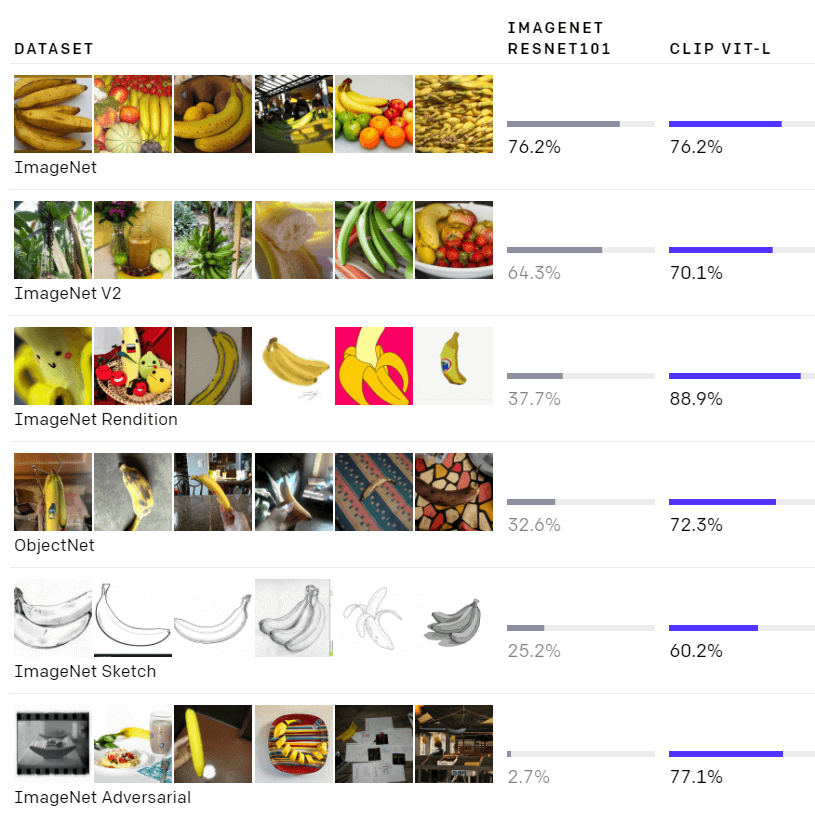

**Грубо говоря**
Идея сводится к тому, что мы:
1. Соединяем текстовое описание и изображение вместе (не только метку класса)
2. Обучаем вместе эти пары через encode изображения и текста
3. Тем самым модель выучивает общую информацию об объектах и получает способность zero-shot classification

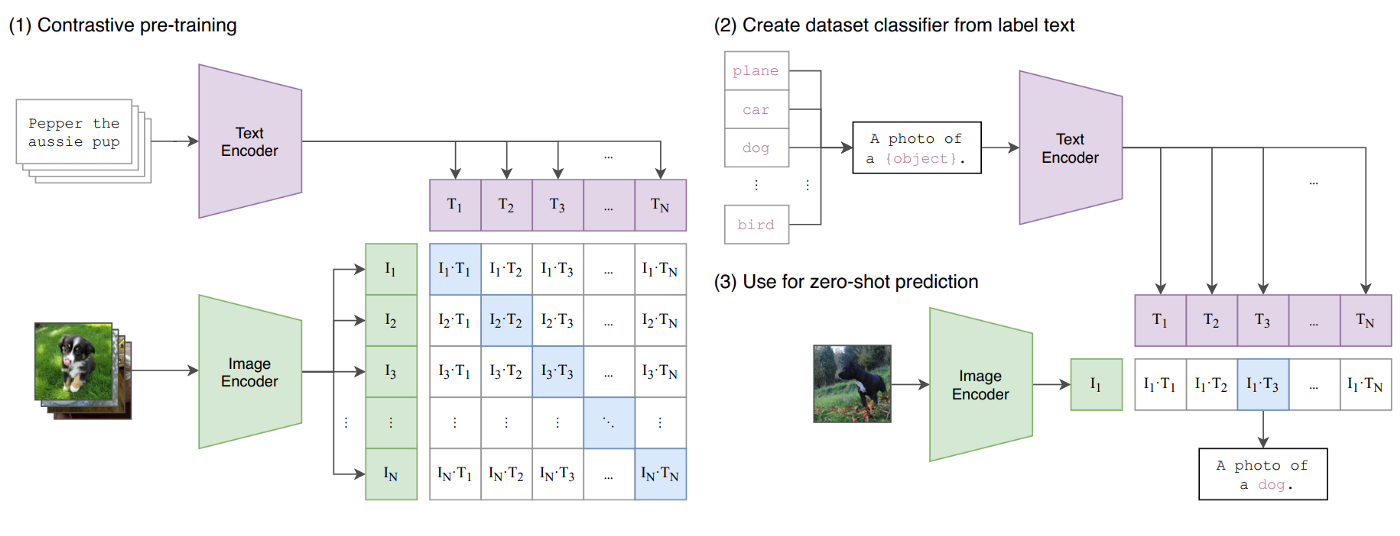

### Ограничения:

1. Плохо считает количество объектов, а также путается на цифрах, например, на MNIST
2. Если уходить в глубину класса - порода собаки или марка машины, то ошибка сильно возрастает

### Попробуем посмотреть примеры:

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-s2o9zupk
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-s2o9zupk
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=c0bb537c4b1bb2937b3bb3d5ad8b2b8e8d88751aa892d17c848c375211a4aa63
  Stored in directory: /tmp/pip-ephem-wheel-cache-5b75z_ip/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.12.1+cu113


В статье указано несколько архитектур на которых тестировались модели. Можем их посмотреть:

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Мы берем на основе ViT модели (Vision Transformer) архитектуру, так как с точки зрения результатов и скорости инференса для нас лучший вариант.

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 125MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
# Чувствительна к размеру картинки, а также к центрированию
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fdcde3665f0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

Посмотрим что происходит, когда мы токенизируем слово-предложение

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [34]:
# Пространство эмбедингов длины 77
clip.tokenize("Hello World!").size()

torch.Size([1, 77])

Посмотрим насколько хорошо модель понимает разные по написанию, но схожие по сути предложения

In [29]:
tensor1 = clip.tokenize("google cloud platform").to(torch.float32)
tensor2 = clip.tokenize("amazon web services").to(torch.float32)

In [30]:
cos = torch.nn.CosineSimilarity(dim=1)
output = cos(tensor1, tensor2)
print(output)

# Как видим весьма неплохо понимает схожие объекты

tensor([0.9993])


### Возьмем базовый пример из гайда

In [36]:
import os
from collections import OrderedDict

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import skimage
import torch
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
}

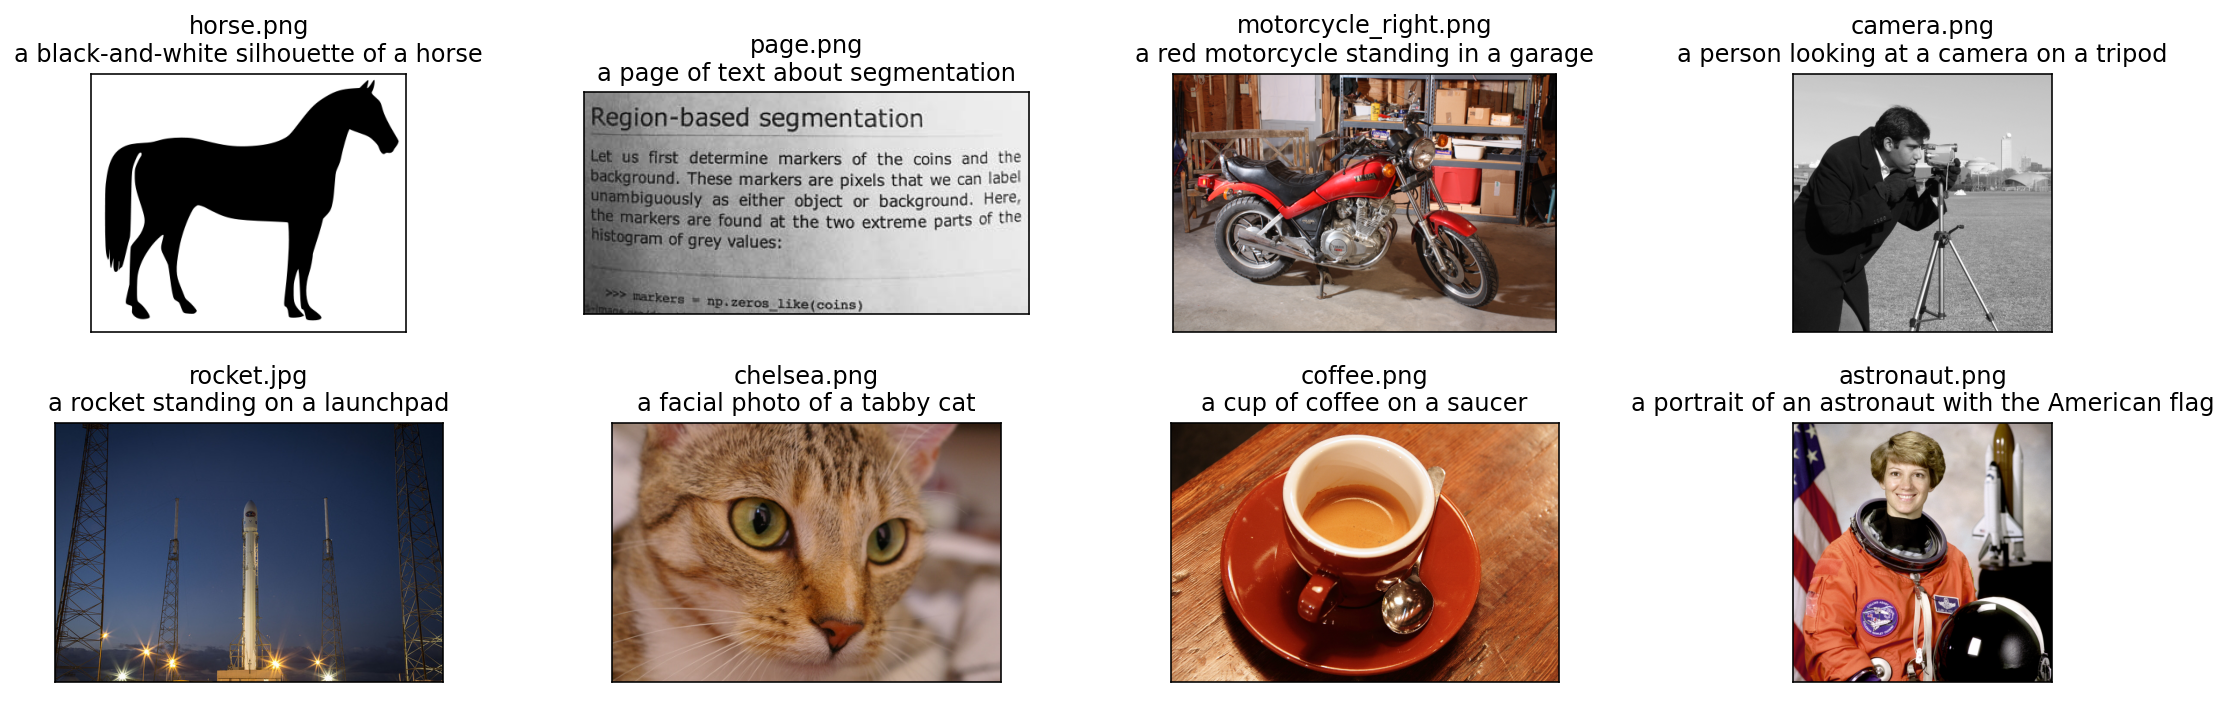

In [37]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [
    filename
    for filename in os.listdir(skimage.data_dir)
    if filename.endswith(".png") or filename.endswith(".jpg")
]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

### Pre-processing



In [38]:
image_input = torch.tensor(np.stack(images)).cuda()

# Добавляем this is - модель лучше работает, когда мы ей достаточно конкретно указываем, что хотим получтиь
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [39]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

### Косинусное растояние

In [40]:
image_features /= image_features.norm(
    dim=-1, keepdim=True
)  # нормализуем для операции сравнения
text_features /= text_features.norm(
    dim=-1, keepdim=True
)  # нормализуем для операции сравнения
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [45]:
similarity

array([[0.3459756 , 0.1725329 , 0.16735964, 0.21315634, 0.14872158,
        0.14575896, 0.15423684, 0.11465593],
       [0.20010248, 0.35392177, 0.1631618 , 0.20154662, 0.15957429,
        0.20116054, 0.19832003, 0.14674538],
       [0.16221228, 0.14264314, 0.32064143, 0.11974154, 0.1593154 ,
        0.15414533, 0.12509575, 0.15481272],
       [0.1951042 , 0.1885449 , 0.16062424, 0.30479646, 0.20693901,
        0.20822401, 0.13662523, 0.18592423],
       [0.1699121 , 0.17406593, 0.1581871 , 0.2016019 , 0.302867  ,
        0.17756572, 0.13833383, 0.19182518],
       [0.15257704, 0.12082499, 0.12479598, 0.1596325 , 0.11868436,
        0.3074323 , 0.1660551 , 0.11932333],
       [0.15405306, 0.14361823, 0.12155243, 0.17416988, 0.1227429 ,
        0.18385416, 0.29316735, 0.14817622],
       [0.16261134, 0.12985885, 0.15003094, 0.16570508, 0.22062907,
        0.16807202, 0.14953117, 0.2767351 ]], dtype=float32)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

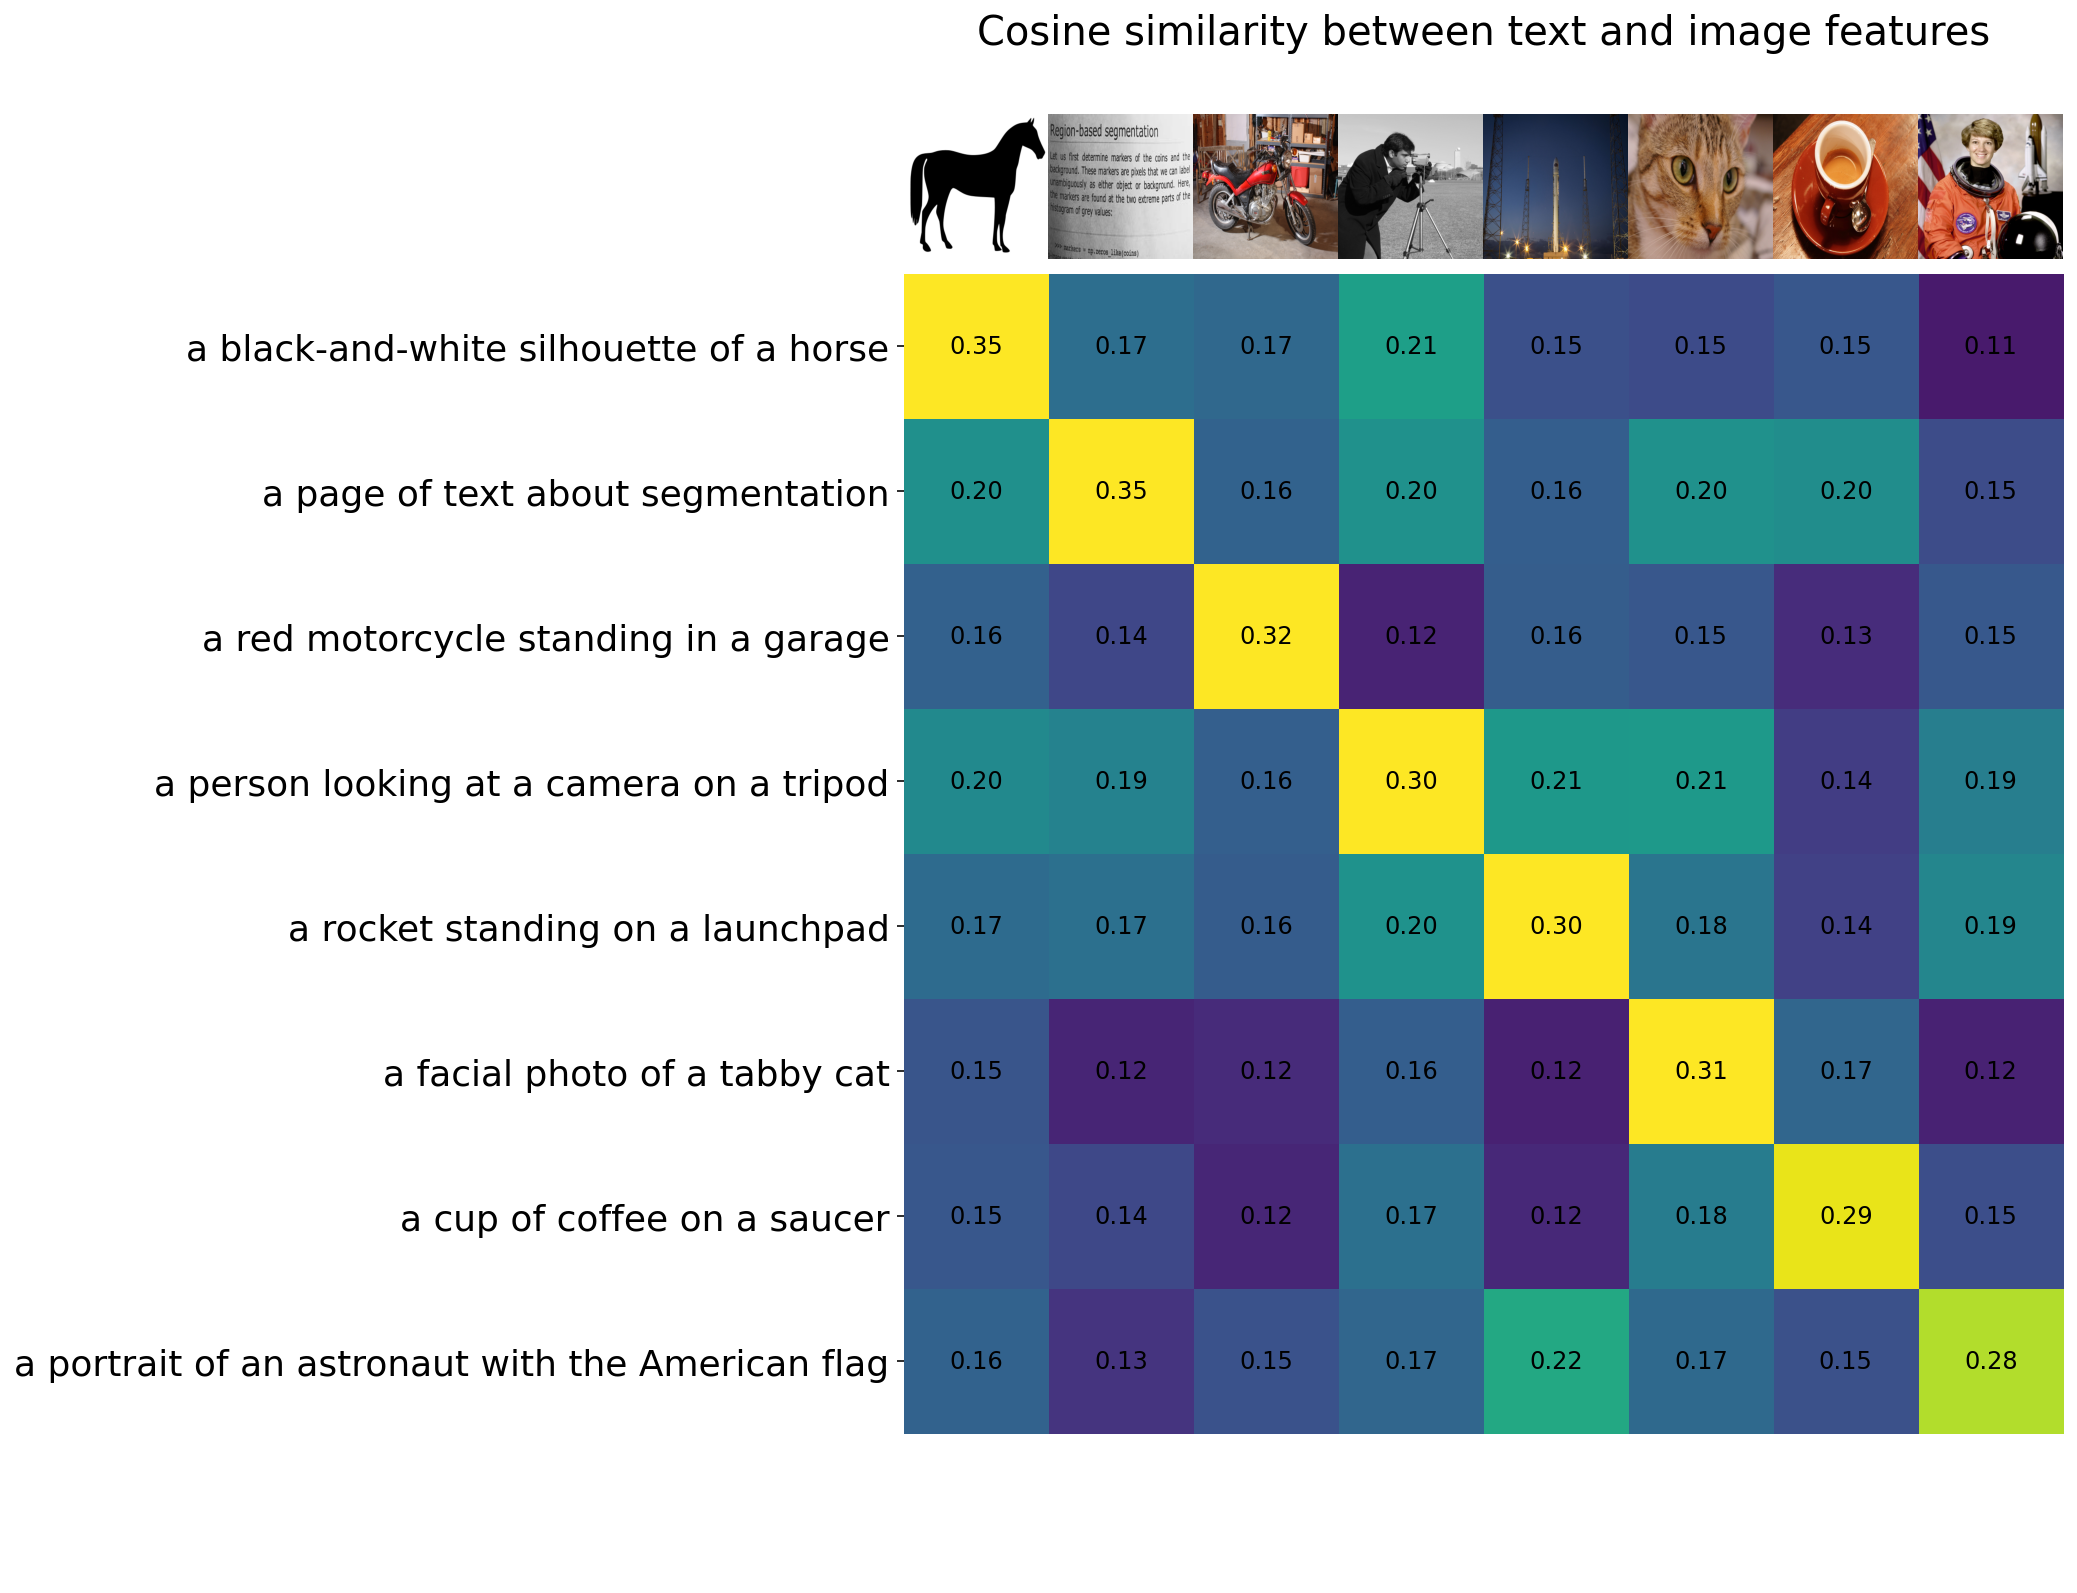

In [55]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

### Zero-shot классификация

In [56]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [57]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [58]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

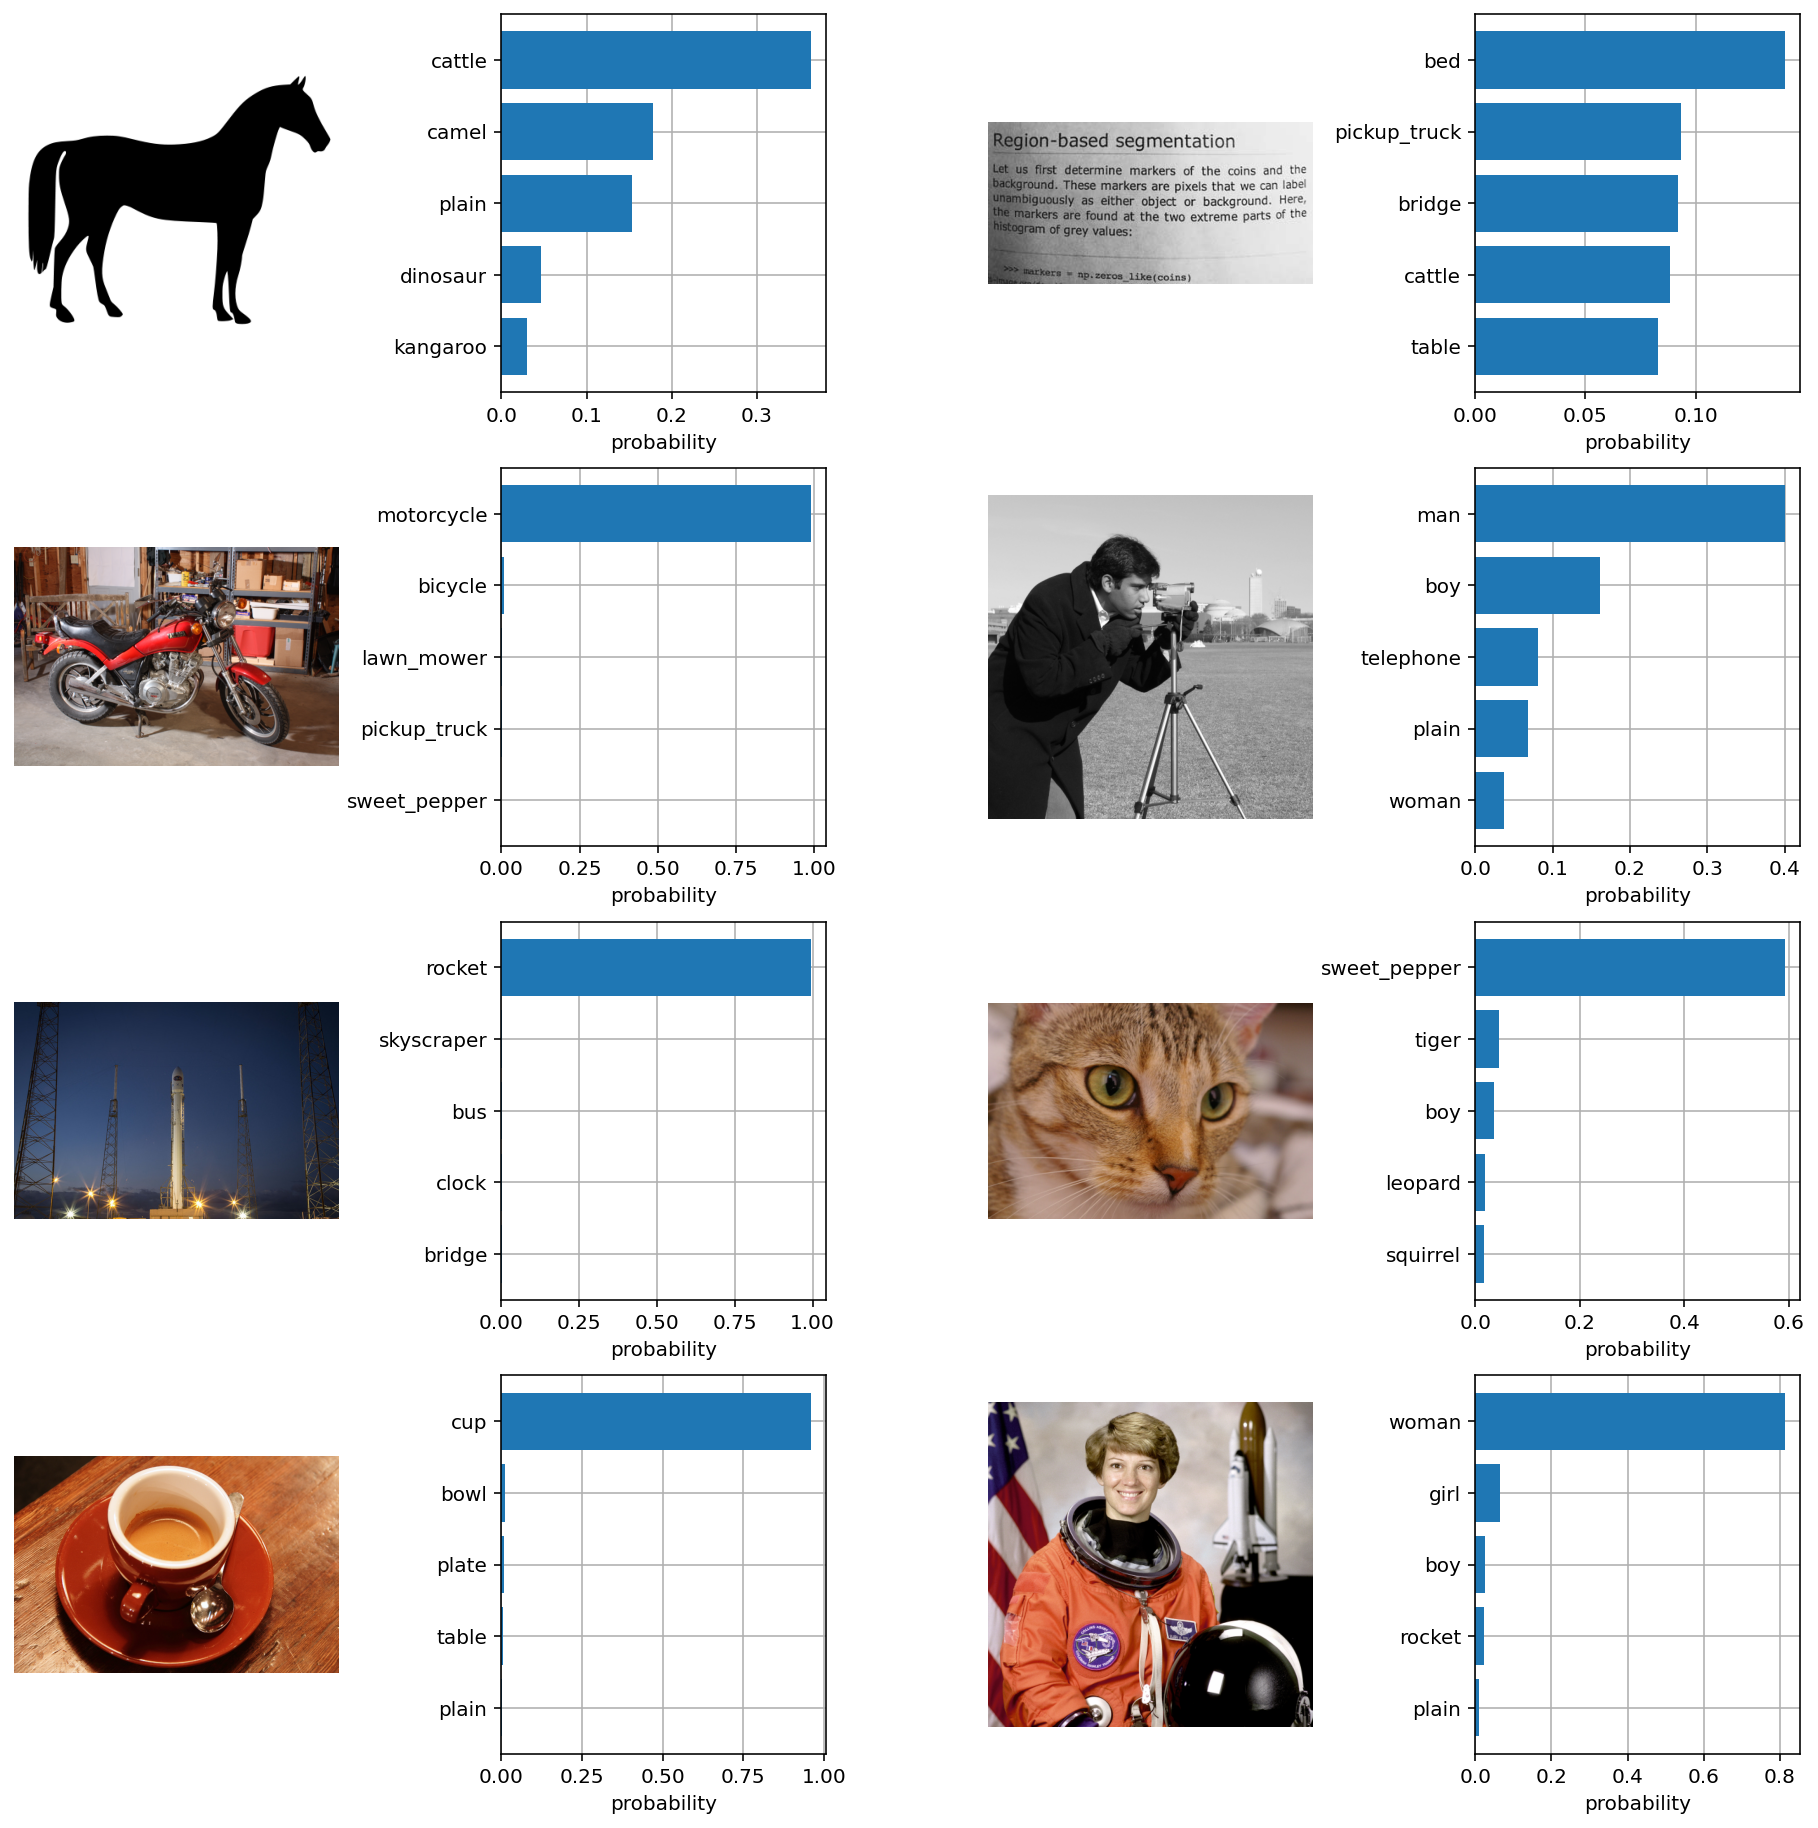

In [59]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()